In [4]:
import torch
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ITRS, GCRS
from astropy.time import Time
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from tqdm import trange

# 1. Setup Constants using Astropy
MU = const.GM_earth.to(u.m**3 / u.s**2).value  # GM
R_E = const.R_earth.to(u.m).value              # Earth Equatorial Radius

# Zonal Harmonics (WGS84 / EGM96 typical values)
J_COEFFS = {
    2: 1.0826263e-3,
    3: -2.532656e-6,
    4: -1.619620e-6,
    5: -0.227296e-6,
    6: 0.540681e-6
}

# 1. Scaling Factors
R_REF = 42164140.0
V_REF = 3074.6
scaling = torch.tensor([R_REF, R_REF, R_REF, V_REF, V_REF, V_REF], dtype=torch.float64)

################################################################################
#################################################################################
def thrust_model(time):
    # Placeholder for thrust model
    # X- is sinusoidal thrust in +x direction with amplitude 2e-5 m/s² and period of 24 hours
    x_thrust = 1.80e-5 * torch.sin(2 * np.pi * time / (24 * 3600))
    # Y- is sinusoidal thrust in +y direction with amplitude 2e-5 m/s² and period of 24 hours shifted by 12 hours
    y_thrust = 2.50e-5 * torch.sin(2 * np.pi * (time - 14*3600) / (24 * 3600)) 
    #Z- is sinusoidal thrust in +z direction with amplitude 4e-5 m/s² and period of 24 hours shifted by 8 hours
    z_thrust = 4.85e-5 * torch.sin(2 * np.pi * (time + 8*3600) / (24 * 3600))

    return torch.tensor([x_thrust, y_thrust, z_thrust], dtype=torch.float64)  # m/s²

#################################################################################
# Define the physics model for use in ODE solver
def physics_model(time, state):
    # state X = [rx, ry, rz, vx, vy, vz]
    r_vec = state[0:3]
    v_vec = state[3:6]
    
    r_mag = torch.norm(r_vec)
    z = r_vec[2]
            
    # --- Keplerian Acceleration (Two-Body) ---
    a_kepler = -MU * r_vec / (r_mag**3)
    
    # --- Perturbing Acceleration (J2) ---
    
    # Explicit Cartesian components for J2 (High performance)
    # Based on Equation 4 context
    j2_factor = (3/2) * J_COEFFS[2] * MU * (R_E**2) / (r_mag**4)
    z2_r2 = (z**2) / (r_mag**2)
    a_j2 = j2_factor * torch.stack([
        (r_vec[0]/r_mag) * (5*z2_r2 - 1),
        (r_vec[1]/r_mag) * (5*z2_r2 - 1),
        (r_vec[2]/r_mag) * (5*z2_r2 - 3)
    ])

    # Here we add J2 
    total_accel = a_kepler + a_j2 

    return torch.cat([v_vec, total_accel])

###############################################################################
# ODE Model for Satellite Dynamics assuming no thrust and only J2 perturbation
class SatelliteODE(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t, state):
        # state X = [rx, ry, rz, vx, vy, vz]
        r_vec = state[0:3]
        v_vec = state[3:6]
        
        a_grav = physics_model(t, state)[3:6]
        
        return torch.cat([v_vec, a_grav]) 

#############################################################################

# ODE assuming continuous thrust to generate the data
class SatelliteODEThrust(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t, state):
        # state X = [rx, ry, rz, vx, vy, vz]
        r_vec = state[0:3]
        v_vec = state[3:6]
        
        # Get gravitational acceleration including J2
        a_grav = physics_model(t, state)[3:6]

        # Generate thrust acceleration (example: constant thrust in +x direction)
        a_thrust = thrust_model(t)

        total_accel = a_grav + a_thrust
        
        return torch.cat([v_vec, total_accel])
    
# ---------------------------------------------------------------------------
# Define a "physics only" solver
class SatelliteODEPhysicsOnly(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t, state):

        with torch.set_grad_enabled(True):
            # state X = [rx, ry, rz, vx, vy, vz]
            r_vec = state[0:3]
            v_vec = state[3:6]
            
            a_grav = physics_model(t, state)[3:6]
            
            return torch.cat([v_vec, a_grav])
        
# ---------------------------------------------------------------------------
# Define class for creating MLP with inputs (number of layers, neurons per layer, activation function)
class MLP(torch.nn.Module):
    def __init__(self, input_size = 7, output_size = 3, hidden_layers = 2, neurons_per_layer = 100):
        super(MLP, self).__init__()
        # Enforce float64 to match your ODE solver
        self.input_size = input_size
        
        layers = []
        layers.append(torch.nn.Linear(input_size, neurons_per_layer))
        layers.append(torch.nn.Tanh()) # Tanh is preferred for PINNs (smooth second derivatives)

        for _ in range(hidden_layers - 1):
            layers.append(torch.nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(torch.nn.Tanh())

        layers.append(torch.nn.Linear(neurons_per_layer, output_size))
        self.network = torch.nn.Sequential(*layers).to(torch.float64)

        torch.nn.init.zeros_(self.network[-1].weight)
        torch.nn.init.zeros_(self.network[-1].bias)

    def forward(self, t, state):
        # Concatenate time and state into a single input vector [t, x, y, z, vx, vy, vz]
        # t is often a scalar, so we expand it
        if t.dim() == 0:
            t = t.unsqueeze(0)
        
        # FEATURE SCALING: Crucial for PINNs
        # Normalize t by mission duration and state by GEO radius/velocity
        # This keeps inputs around [-1, 1]
        t_norm = t / 172800.0 # Example: 48 hours in seconds
        state_norm = state / scaling # Using your previously defined scaling tensor
        
        x_input = torch.cat([t_norm, state_norm])
        
        # The output is the 'Anomalous Acceleration' (g)
        return self.network(x_input) * 1e-7  # Scale output to realistic acceleration magnitudes


# Define a hybrid ODE model combining physics and neural network
class PINN(torch.nn.Module):
    def __init__(self, neural_net):
        super().__init__()
        self.neural_net = neural_net

    def forward(self, t, state):
        # state X = [rx, ry, rz, vx, vy, vz]
        r_vec = state[0:3]
        v_vec = state[3:6]
        
        # Get gravitational acceleration including J2
        a_grav = physics_model(t, state)[3:6]
        
        # Get neural network acceleration prediction
        a_nn = self.neural_net(t, state)
        
        # Combine physics and neural network
        total_accel = a_grav + a_nn
        
        return torch.cat([v_vec, total_accel])

In [7]:
# Initialize seed for reproducibility
torch.manual_seed(42)

Define an arbitrary thrust profile:

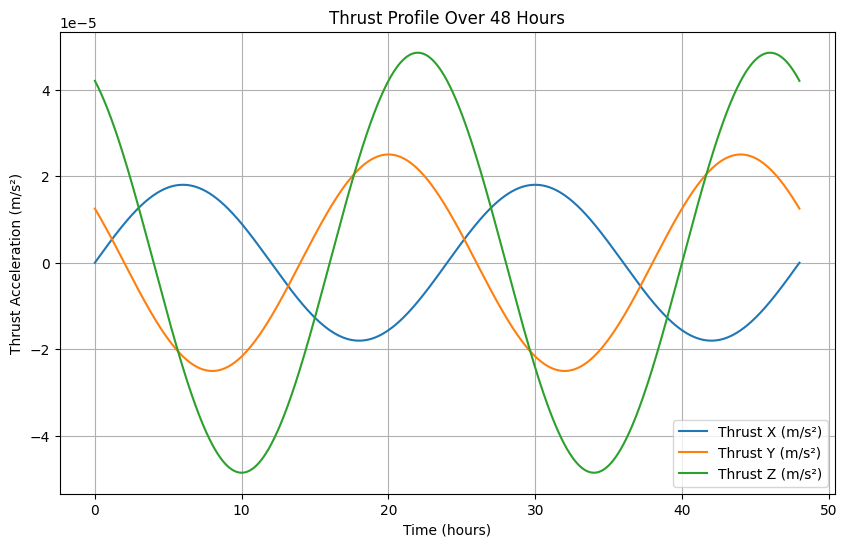

In [ ]:
# plot the thrust profile over 48 hours
time_array = torch.arange(0, 3600*48 + 10, 10, dtype=torch.float64)
thrust_profile = torch.stack([thrust_model(t) for t in time_array])


plt.figure(figsize=(10, 6))
plt.plot(time_array.numpy()/3600, thrust_profile[:,0].numpy(), label='Thrust X (m/s²)')
plt.plot(time_array.numpy()/3600, thrust_profile[:,1].numpy(), label='Thrust Y (m/s²)')
plt.plot(time_array.numpy()/3600, thrust_profile[:,2].numpy(), label='Thrust Z (m/s²)')
plt.xlabel('Time (hours)')
plt.ylabel('Thrust Acceleration (m/s²)')
plt.title('Thrust Profile Over 48 Hours')
plt.legend()
plt.grid()
plt.show()  

Ensure the Delta-V is reasonable and approx. 10 m/s:

In [9]:
# Integrate all 3 components of thrust over 48 hours to get delta-V
delta_v = torch.zeros(3, dtype=torch.float64)
for t in time_array:
    delta_v += abs(thrust_model(t)) * 10  # 10 seconds step  
print(f"Total Delta-V over 48 hours: {delta_v.numpy()} m/s")

# sum of absolute values of delta-v components
total_delta_v = torch.sum(delta_v).item()

print(f"Sum of absolute Delta-V components: {total_delta_v:.4f} m/s")


Total Delta-V over 48 hours: [1.98014205 2.7503223  5.33580278] m/s
Sum of absolute Delta-V components: 10.0663 m/s


Define and propagate the initial orbital state for 48 hours:

Inclined GEO Initial State (i=5°, e=0):
tensor([4.2164e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0736e+03, 8.0485e+01],
       dtype=torch.float64)
Inclination: 1.5°
Eccentricity: 0.0 (Circular)
Inclined GEO Initial State Vector:
tensor([4.2164e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0736e+03, 8.0485e+01],
       dtype=torch.float64)


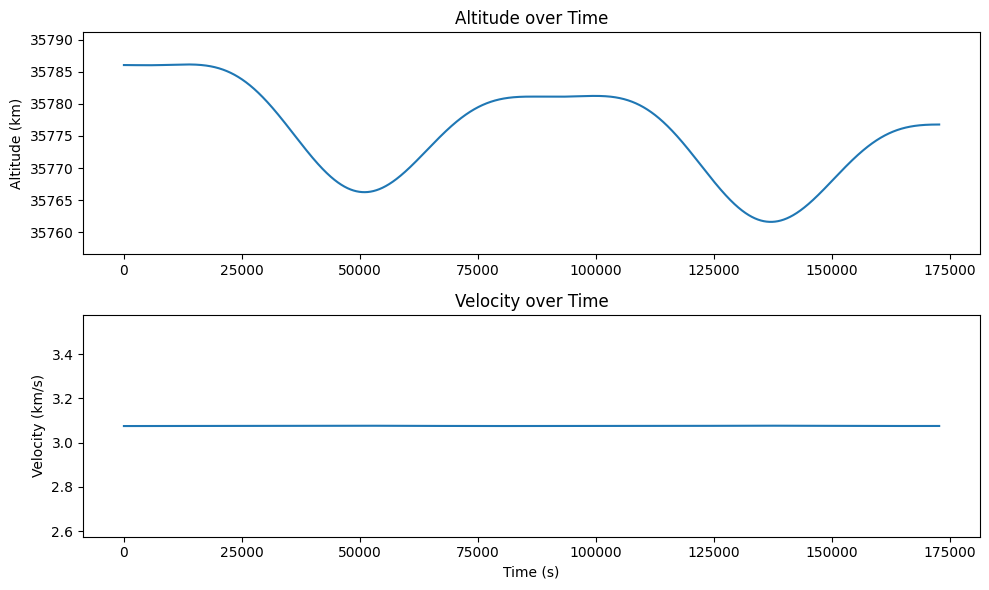

In [10]:
# 1. GEO Parameters
r_geo_mag = 42164140.0 # meters (Semi-major axis for circular GEO)
mu = const.GM_earth.value

# 2. Calculate Circular Velocity Magnitude
# v = sqrt(mu / r)
v_circ_mag = np.sqrt(mu / r_geo_mag)

# 3. Define Orbital Elements
inclination_deg = 1.5
i_rad = np.radians(inclination_deg)

# 4. Construct the State Vector
# Position: Place the satellite on the X-axis (Line of Nodes)
r_0 = torch.tensor([r_geo_mag, 0.0, 0.0], dtype=torch.float64)

# Velocity: Rotate the velocity vector around the X-axis by the inclination
# For a satellite at the node (on X), the velocity in an equatorial orbit is purely on Y.
# Tilted velocity: Vy = v*cos(i), Vz = v*sin(i)
v_0 = torch.tensor([
    0.0, 
    v_circ_mag * np.cos(i_rad), 
    v_circ_mag * np.sin(i_rad)
], dtype=torch.float64)

# Combined State Vector X = [r, v]
x0_inclined = torch.cat([r_0, v_0])

print(f"Inclined GEO Initial State (i=5°, e=0):\n{x0_inclined}")
print(f"Inclination: {inclination_deg}°")
print(f"Eccentricity: 0.0 (Circular)")

print(f"Inclined GEO Initial State Vector:\n{x0_inclined}")
#print(f"Initial Altitude: {(r_geo_mag - const.R_earth).to(u.km):.2f}")

# 2. Propagation Execution
#t = torch.linspace(0, 3600*48,1000) # Propagate for 2 days
# define the t-tensor so that the integration step is 10 seconds
t = torch.arange(0, 3600*48 + 10, 10, dtype=torch.float64)

model = SatelliteODEThrust()
# Use 'dopri5' or 'rk4' for integration
with torch.no_grad():
    trajectory = odeint(model, x0_inclined, t, method='rk4')
# Compute altitude and velocity
r_mag = torch.norm(trajectory[:, :3], dim=1)
altitude = r_mag - const.R_earth.to(u.m).value
velocity = torch.norm(trajectory[:, 3:], dim=1)

# Plot altitude and velocity

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(t.numpy(), altitude.numpy()/1000)
ax1.set_title('Altitude over Time')
ax1.set_ylabel('Altitude (km)')
ax1.set_ylim(altitude.numpy().min()/1000-5, altitude.numpy().max()/1000+5)

ax2.plot(t.numpy(), velocity.numpy()/1000)
ax2.set_title('Velocity over Time')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (km/s)')
ax2.set_ylim(velocity.numpy().min()/1000-0.5, velocity.numpy().max()/1000+0.5)
plt.tight_layout()
plt.show()



In [11]:
t.numpy().shape

(17281,)

In [12]:
t.numpy()[0:10]

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [13]:

def calculate_ra_dec_eci(trajectory):
    """
    Differentiable ECI RA/Dec calculation.
    Input trajectory: Tensor of shape (30, 6)
    """
    # 1. Extract position components
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    z = trajectory[:, 2]
    
    # 2. Calculate magnitude using torch.norm (dim=1 for the 30 rows)
    r_mag = torch.norm(trajectory[:, :3], dim=1)
    
    # 3. Calculate Right Ascension (RA)
    # Use torch.atan2 and convert to degrees
    ra = torch.atan2(y, x) * (180.0 / torch.pi)
    
    # Use torch.remainder for the 0-360 wrap-around
    # This is differentiable, whereas 'if/else' logic or numpy modulo is not
    ra = torch.remainder(ra, 360.0)
    
    # 4. Calculate Declination (Dec)
    # Use torch.asin and convert to degrees
    dec = torch.asin(z / r_mag) * (180.0 / torch.pi)

    return ra, dec

def plot_ra_dec_eci(t, trajectory):
    # Convert time to hours
    if hasattr(t, 'detach'):
        t_plot = t.detach().cpu().numpy() / 3600.0
    else:
        t_plot = np.array(t) / 3600.0

    ra, dec = calculate_ra_dec_eci(trajectory)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.suptitle('Geocentric ECI Observations', fontsize=14)

    # RA Plot
    ax.scatter(t_plot, ra, color='royalblue', s=1, label='Right Ascension')
    # Dec Plot
    ax.scatter(t_plot, dec, color='red', s=1, label='Declination')

    ax.set_ylabel('Degrees')
    ax.set_xlabel('Time (hours)')
    ax.set_ylim(-100, 100)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()


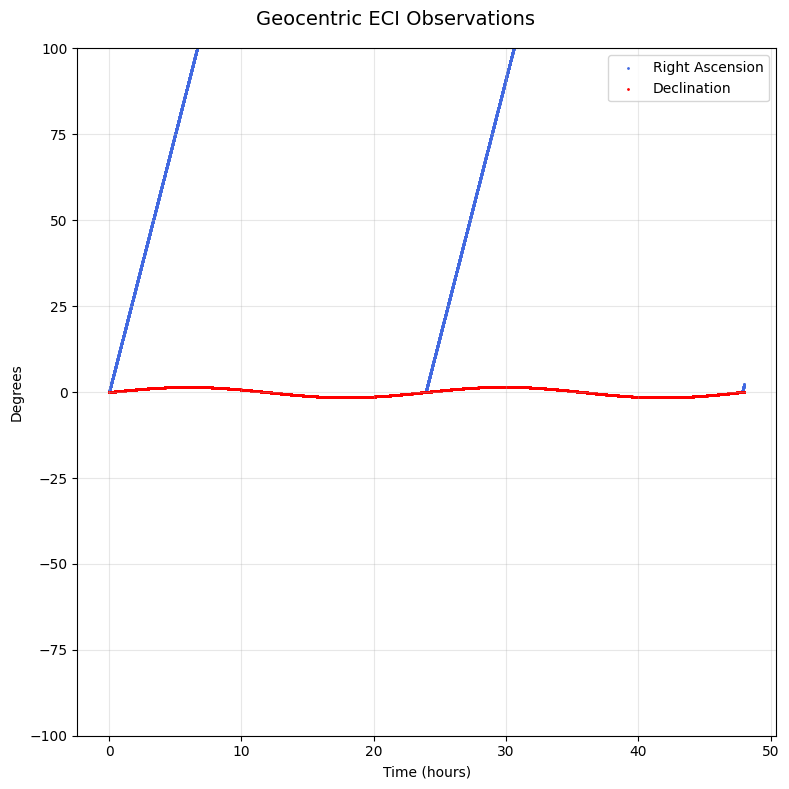

In [14]:
plot_ra_dec_eci(t, trajectory)

<br>

In [15]:
# Get 50 random observation times within the propagation period
num_observations = 250

# Ensure the first observation (index 0) is always included
# Choose 49 random indices from 1 to len(t)-1
additional_indices = np.random.choice(np.arange(1, len(t)), size=num_observations-1, replace=False)
observation_indices = np.sort(np.concatenate([[0], additional_indices]))
observation_times = t[observation_indices]

In [16]:
observation_times

tensor([0.0000e+00, 1.6000e+02, 4.6000e+02, 9.2000e+02, 1.1300e+03, 1.4700e+03,
        4.8100e+03, 6.4600e+03, 7.8500e+03, 8.9900e+03, 1.1280e+04, 1.3030e+04,
        1.3750e+04, 1.5110e+04, 1.5230e+04, 1.5290e+04, 1.6020e+04, 1.6140e+04,
        1.6750e+04, 1.6810e+04, 1.7310e+04, 1.7870e+04, 1.8190e+04, 1.8820e+04,
        1.8860e+04, 2.1400e+04, 2.1580e+04, 2.2100e+04, 2.2130e+04, 2.2520e+04,
        2.4850e+04, 2.5620e+04, 2.6640e+04, 2.7330e+04, 2.7820e+04, 2.7970e+04,
        2.8010e+04, 2.9730e+04, 2.9760e+04, 3.0400e+04, 3.1380e+04, 3.1880e+04,
        3.2910e+04, 3.4010e+04, 3.4020e+04, 3.5160e+04, 3.6310e+04, 3.6350e+04,
        3.6540e+04, 3.6680e+04, 3.6730e+04, 3.6740e+04, 3.6980e+04, 3.7150e+04,
        3.7180e+04, 3.7870e+04, 3.8830e+04, 3.9450e+04, 3.9770e+04, 4.0460e+04,
        4.0480e+04, 4.1100e+04, 4.1240e+04, 4.1460e+04, 4.2130e+04, 4.4450e+04,
        4.4730e+04, 4.4790e+04, 4.4900e+04, 4.6370e+04, 4.6710e+04, 4.6830e+04,
        4.7990e+04, 4.8360e+04, 4.8420e+

In [17]:
# Get RA and Dec at observation times
ra_obs, dec_obs = calculate_ra_dec_eci(trajectory[observation_indices])

# Add noise to observations, from a normal distribution with mean 0 and stddev 0.5 arcseconds
noise_stddev_arcsec = 0.5
noise_stddev_deg = noise_stddev_arcsec / 3600.0  # Convert to degrees

ra_noise = np.random.normal(0, noise_stddev_deg, size=len(ra_obs))

ra_obs_noisy = ra_obs + ra_noise


dec_noise = np.random.normal(0, noise_stddev_deg, size=len(dec_obs))

dec_obs_noisy = dec_obs + dec_noise

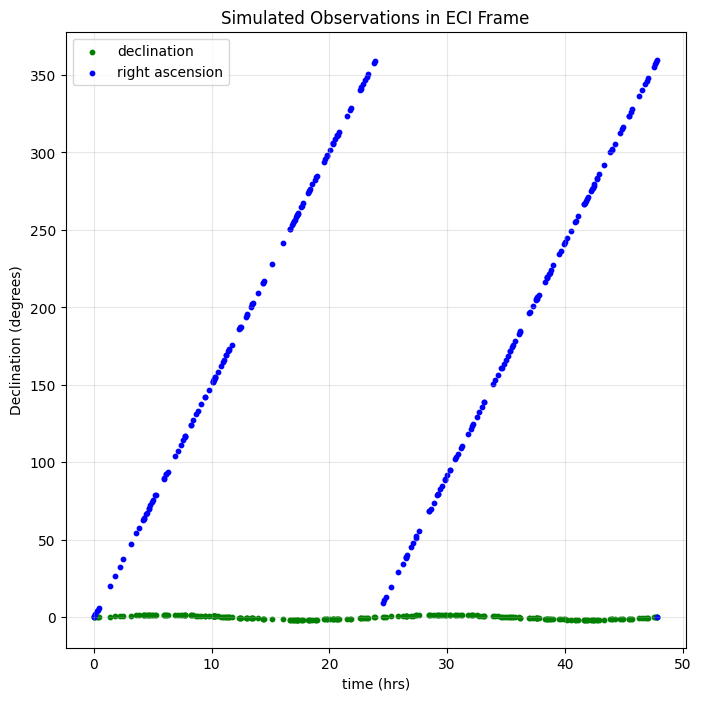

In [18]:
# Plot the observations
fig, ax = plt.subplots(figsize=(8, 8))
# Plot RA observations
ax.scatter(observation_times/3600.0, dec_obs_noisy, color='green', s=10, label='declination')
ax.scatter(observation_times/3600.0, ra_obs_noisy, color='blue', s=10, label='right ascension')
ax.set_xlabel('time (hrs)')  
ax.set_ylabel('Declination (degrees)')
ax.set_title('Simulated Observations in ECI Frame')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()



In [19]:
ra_obs_noisy_tensor = torch.tensor(ra_obs_noisy, dtype=torch.float64)
dec_obs_noisy_tensor = torch.tensor(dec_obs_noisy, dtype=torch.float64)

C:\Users\nicol\AppData\Local\Temp\ipykernel_16508\2395300352.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ra_obs_noisy_tensor = torch.tensor(ra_obs_noisy, dtype=torch.float64)
C:\Users\nicol\AppData\Local\Temp\ipykernel_16508\2395300352.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dec_obs_noisy_tensor = torch.tensor(dec_obs_noisy, dtype=torch.float64)


Solve using physics-only model

In [20]:
def circular_mse_loss(pred_deg, target_deg):
    """
    Calculates MSE while accounting for the 0/360 degree wrap-around.
    """
    # Convert degrees to radians
    pred_rad = pred_deg * (torch.pi / 180.0)
    target_rad = target_deg * (torch.pi / 180.0)
    
    # Method 1: Difference based
    # Calculate shortest angular distance
    diff = torch.atan2(torch.sin(pred_rad - target_rad), torch.cos(pred_rad - target_rad))
    
    # Return MSE of the shortest distance (in degrees)
    return torch.mean((diff * (180.0 / torch.pi))**2)

In [21]:
def get_better_x0(ra1, dec1, ra2, dec2, delta_t):
    r_geo = 42164140.0 # meters
    
    # Convert degrees to radians
    phi1, theta1 = torch.deg2rad(dec1), torch.deg2rad(ra1)
    phi2, theta2 = torch.deg2rad(dec2), torch.deg2rad(ra2)
    
    # Unit vectors for observations 1 and 2
    L1 = torch.tensor([torch.cos(phi1)*torch.cos(theta1), 
                       torch.cos(phi1)*torch.sin(theta1), 
                       torch.sin(phi1)], dtype=torch.float64)
    
    L2 = torch.tensor([torch.cos(phi2)*torch.cos(theta2), 
                       torch.cos(phi2)*torch.sin(theta2), 
                       torch.sin(phi2)], dtype=torch.float64)
    
    # Position guess
    pos0 = L1 * r_geo
    pos1 = L2 * r_geo
    
    # Velocity guess: (Change in position) / (Change in time)
    vel0 = (pos1 - pos0) / delta_t
    
    return torch.cat([pos0, vel0])

# Use your first two data points
x0_improved = get_better_x0(ra_obs_noisy_tensor[0], dec_obs_noisy_tensor[0], ra_obs_noisy_tensor[1], dec_obs_noisy_tensor[1], observation_times[1]-observation_times[0])
x0_guess_init = torch.nn.Parameter(x0_improved, requires_grad=True)

In [22]:
x0_guess_init

Parameter containing:
tensor([ 4.2164e+07,  1.2180e+02,  7.7368e+01, -1.7940e+01,  3.0731e+03,
         8.1577e+01], dtype=torch.float64, requires_grad=True)

In [23]:


# 2. Define the Normalized Initial State
# Start with your 'best_x0' from the IOD, but divide by scaling
x0_norm = torch.nn.Parameter(x0_guess_init / scaling)

# 3. LBFGS is specifically designed for Batch Least Squares problems
optimizer = torch.optim.LBFGS([x0_norm], lr=1e-1, max_iter=100, history_size=10, tolerance_grad=1e-9, tolerance_change=1e-11, line_search_fn='strong_wolfe')
pure_physics_model = SatelliteODEPhysicsOnly()
def closure():
    optimizer.zero_grad()
    # Unscale inside the physics model
    x0_unscaled = x0_norm * scaling
    
    # Propagate through the 30 observations
    traj = odeint(pure_physics_model, x0_unscaled, observation_times, method='rk4')
    ra_p, dec_p = calculate_ra_dec_eci(traj)
    
    # Calculate Residuals
    loss = circular_mse_loss(ra_p, ra_obs_noisy_tensor) + torch.mean((dec_p - dec_obs_noisy_tensor)**2)
    loss.backward()

    # return loss and x0_unscaled
    return loss

# store best x0 guess_ols = None
best_x0_guess_ols = None
best_loss_ols = float('inf')
# Run the 'OLS' Iterations
for i in range(10):
    loss = optimizer.step(closure)
    x0_guess_ols = x0_norm.data * scaling
    print(f"OLS Iteration {i}: Loss = {loss.item():.6f}")

    if best_x0_guess_ols is None or loss.item() < best_loss_ols:
        best_x0_guess_ols = x0_guess_ols.clone()
        best_loss_ols = loss.item()

OLS Iteration 0: Loss = 0.897172
OLS Iteration 1: Loss = 0.000269
OLS Iteration 2: Loss = 0.000269
OLS Iteration 3: Loss = 0.000269
OLS Iteration 4: Loss = 0.000269
OLS Iteration 5: Loss = 0.000269
OLS Iteration 6: Loss = 0.000269
OLS Iteration 7: Loss = 0.000269
OLS Iteration 8: Loss = 0.000269
OLS Iteration 9: Loss = 0.000269


In [24]:
best_x0_guess_ols

tensor([ 4.2163e+07, -1.1902e+03,  1.3154e+04,  6.0151e-01,  3.0734e+03,
         8.2110e+01], dtype=torch.float64)

In [25]:
# guess an initial state where rx_0 and rz_0 are zero, and ry_0 is at GEO radius
#x0_guess = torch.tensor([r_geo_mag, 0.0, 0.0, 0.0, v_circ_mag, 0.0], dtype=torch.float64, requires_grad=True)  # Initial guess state
x0_guess = torch.nn.Parameter(best_x0_guess_ols.clone().detach()/scaling, requires_grad=True)
# 2. Setup Optimizer
# We start with a smaller learning rate; x0 is very sensitive for GEO orbits
optimizer = optim.Adam([x0_guess], lr=1e-2)

scheduled_lr = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.98)

pure_physics_model = SatelliteODEPhysicsOnly()

num_epochs = 20000
patience = 200
counter = 0

# Initialize variables to store the best guess
best_loss = float('inf')
best_x0_ols = x0_guess.clone()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    x0_active = x0_guess * scaling  # Unscale for physics model
    
    # Propagate the orbit with the current guess of initial state
    trajectory_guess = odeint(pure_physics_model, x0_active, observation_times, method='rk4')
      
    # Get RA and Dec at observation times
    ra_guess, dec_guess = calculate_ra_dec_eci(trajectory_guess)
    
    # Compute loss as Mean Squared Error between observed and guessed RA/Dec
    loss_ra = circular_mse_loss(ra_guess, ra_obs_noisy_tensor)
    loss_dec = torch.mean((dec_guess - dec_obs_noisy_tensor)**2)
    loss = loss_ra + loss_dec

    # Update best guess if current loss is lower
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_x0_ols = x0_guess.clone().detach()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
    
    # Backpropagation   
    loss.backward()
    optimizer.step()

    scheduled_lr.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    if counter >= patience:
        print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch+1}.")
        break

# After optimization, the best guess is stored in best_x0
print(f"Best Loss: {best_loss:.6f}")
print(f"Best Initial State Guess: {best_x0_ols}") 

Epoch 100/20000, Loss: 0.039593
Epoch 200/20000, Loss: 0.004721
No improvement for 200 epochs. Stopping early at epoch 201.
Best Loss: 0.000269
Best Initial State Guess: tensor([ 9.9997e-01, -2.8227e-05,  3.1198e-04,  1.9564e-04,  9.9962e-01,
         2.6706e-02], dtype=torch.float64)


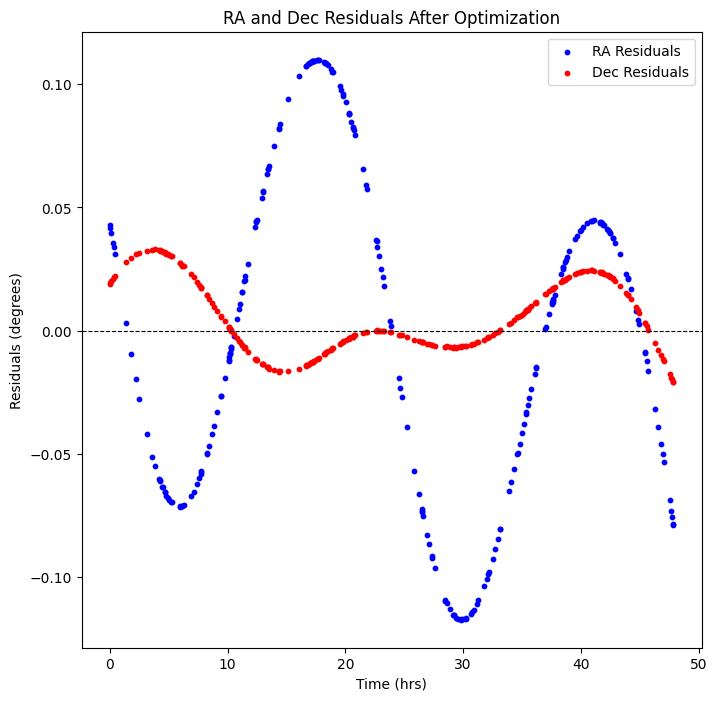

In [26]:
# Plot the residuals
fig, ax = plt.subplots(figsize=(8, 8))

# Compute RA residuals accounting for circular nature (0-360 degrees)
ra_guess_deg = ra_guess.detach().numpy()
ra_obs_deg = ra_obs_noisy.detach().numpy()
ra_diff_rad = np.radians(ra_guess_deg - ra_obs_deg)
ra_residuals = np.degrees(np.arctan2(np.sin(ra_diff_rad), np.cos(ra_diff_rad)))

# Dec residuals (no circular issue)
dec_residuals = dec_guess.detach().numpy() - dec_obs_noisy.detach().numpy()

ax.scatter(observation_times/3600.0, ra_residuals, color='blue', s=10, label='RA Residuals')
ax.scatter(observation_times/3600.0, dec_residuals, color='red', s=10, label='Dec Residuals')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Residuals (degrees)')
ax.set_title('RA and Dec Residuals After Optimization')
ax.legend()
plt.show()

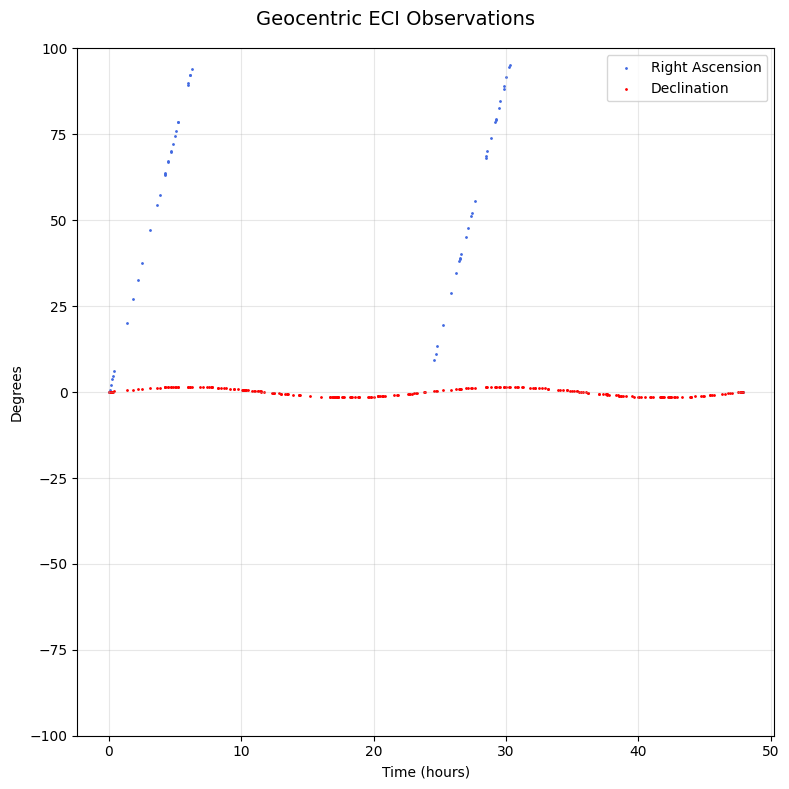

In [27]:
# plot fitted RA and Dec
plot_ra_dec_eci(observation_times.detach(), trajectory_guess.detach())


Try with OLS

In [28]:
x0_guess    

Parameter containing:
tensor([ 1.0009e+00,  7.5638e-04,  3.3666e-04, -6.5355e-04,  9.9870e-01,
         2.6720e-02], dtype=torch.float64, requires_grad=True)

## PINN:

In [ ]:


neural_net = MLP(hidden_layers=2, neurons_per_layer=100)
pinn = PINN(neural_net)

num_epochs = 40000
patience = 2000
counter = 0

# guess an initial state where rx_0 and rz_0 are zero, and ry_0 is at GEO radius
#x0_guess = torch.tensor([r_geo_mag, 0.0, 0.0, 0.0, v_circ_mag, 0.0], dtype=torch.float64, requires_grad=True)  # Initial guess state
x0_guess = torch.nn.Parameter(best_x0_guess_ols.clone().detach(), requires_grad=True)
#x0_guess = torch.nn.Parameter(best_x0_guess_ols.clone().detach(), requires_grad=True)

# 2. Setup Optimizer
# We start with a smaller learning rate; x0 is very sensitive for GEO orbits
optimizer = torch.optim.Adam([
    {'params': neural_net.parameters(), 'lr': 3e-2}, # NN weights
    {'params': [x0_guess], 'lr': 5e-5}         # IC tuning (Smaller LR)
])

scheduled_lr = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.98)

# Initialize variables to store the best guess
best_loss = float('inf')
best_x0 = x0_guess.clone()

for epoch in trange(num_epochs, desc="Training PINN"):
    optimizer.zero_grad()
    x0_active = x0_guess  # Unscale for physics model

    # Propagate the orbit with the current guess of initial state
    trajectory_guess = odeint(pinn, x0_active, observation_times, method='rk4')

    # Get RA and Dec at observation times
    ra_guess, dec_guess = calculate_ra_dec_eci(trajectory_guess)

    # Compute loss as Mean Squared Error between observed and guessed RA/Dec
    loss_ra = circular_mse_loss(ra_guess, ra_obs_noisy_tensor)
    loss_dec = torch.mean((dec_guess - dec_obs_noisy_tensor)**2)
    loss = loss_ra + loss_dec

    # Update best guess if current loss is lower
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_x0 = x0_guess.clone().detach()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1

    # 3. IC Tuning Frequency Logic
    # If this isn't the 5th epoch, wipe the x0 gradient so it doesn't move
    if epoch % 100 != 0:
        if x0_guess.grad is not None:
            x0_guess.grad.zero_()

    # Backpropagation   
    loss.backward()
    optimizer.step()

    scheduled_lr.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

    if counter >= patience:
        print(f"No improvement for {patience} epochs. Stopping early at epoch {epoch+1}.")
        break

# After optimization, the best guess is stored in best_x0
print(f"Best Loss: {best_loss:.6f}")
print(f"Best Initial State Guess: {best_x0}") 

Training PINN:   0%|          | 100/40000 [02:37<17:24:01,  1.57s/it]

Epoch 100/40000, Loss: 0.000146


Training PINN:   0%|          | 200/40000 [05:03<15:00:26,  1.36s/it]

Epoch 200/40000, Loss: 0.000124


Training PINN:   1%|          | 300/40000 [07:30<15:39:32,  1.42s/it]

Epoch 300/40000, Loss: 0.000114


Training PINN:   1%|          | 400/40000 [10:05<16:16:07,  1.48s/it]

Epoch 400/40000, Loss: 0.000107


Training PINN:   1%|          | 431/40000 [10:55<16:38:56,  1.51s/it]

In [31]:
trajectory_guess = odeint(pinn, best_x0, observation_times, method='rk4')

ra_guess_pinn, dec_guess_pinn = calculate_ra_dec_eci(trajectory_guess)


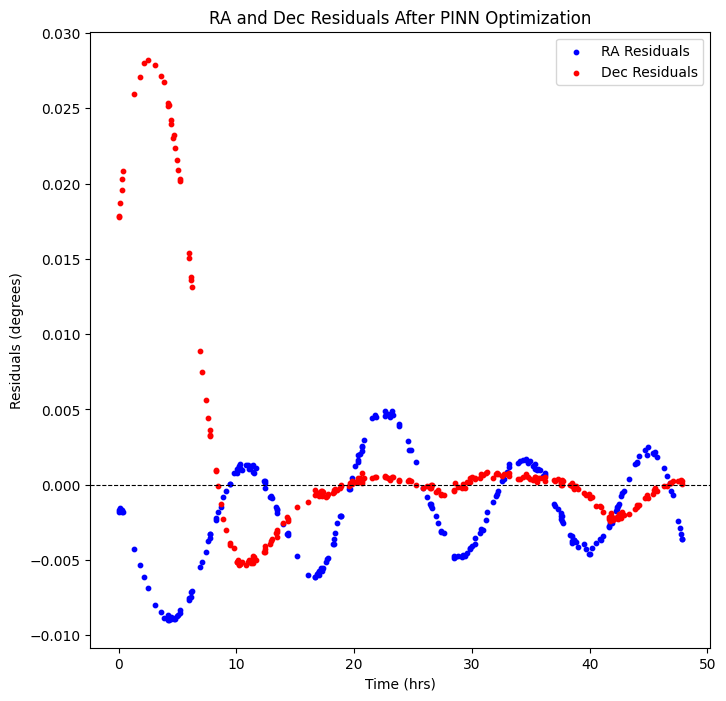

In [32]:
# plot the residuals from the PINN fit
fig, ax = plt.subplots(figsize=(8, 8))
# Compute RA residuals accounting for circular nature (0-360 degrees)
ra_guess_deg = ra_guess_pinn.detach().numpy()
ra_obs_deg = ra_obs_noisy.detach().numpy()
ra_diff_rad = np.radians(ra_guess_deg - ra_obs_deg)
ra_residuals = np.degrees(np.arctan2(np.sin(ra_diff_rad), np.cos(ra_diff_rad)))
# Dec residuals (no circular issue)
dec_residuals = dec_guess_pinn.detach().numpy() - dec_obs_noisy.detach().numpy()
ax.scatter(observation_times/3600.0, ra_residuals, color='blue', s=10, label='RA Residuals')
ax.scatter(observation_times/3600.0, dec_residuals, color='red', s=10, label='Dec Residuals')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Residuals (degrees)')
ax.set_title('RA and Dec Residuals After PINN Optimization')
ax.legend()
plt.show()

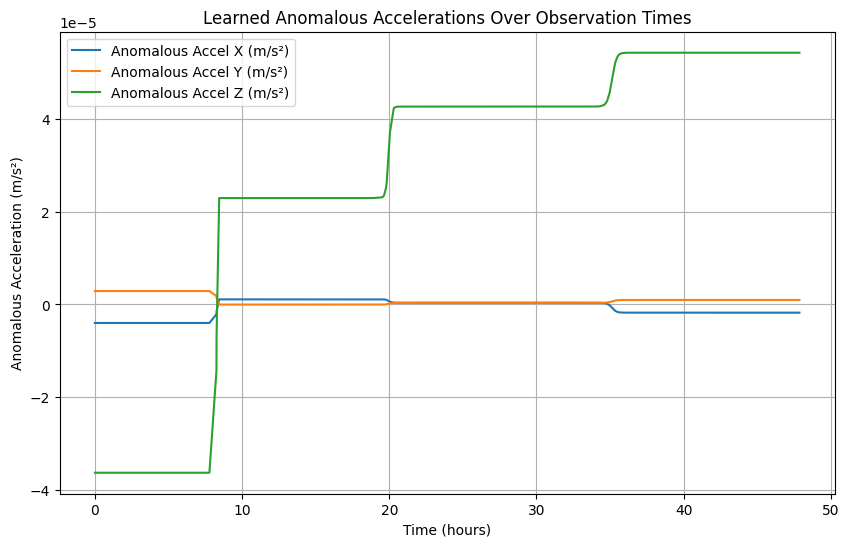

In [33]:
# Get x, y, z components of the anomalous acceleration from the neural network over the observation times
anomalous_accels = torch.stack([neural_net(ti, odeint(pinn, best_x0, torch.tensor([ti], dtype=torch.float64), method='rk4')[-1]) for ti in observation_times])

# Plot the anomalous accelerations
plt.figure(figsize=(10, 6))
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,0].detach().numpy(), label='Anomalous Accel X (m/s²)')
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,1].detach().numpy(), label='Anomalous Accel Y (m/s²)')
plt.plot(observation_times.numpy()/3600, anomalous_accels[:,2].detach().numpy(), label='Anomalous Accel Z (m/s²)')
plt.xlabel('Time (hours)')
plt.ylabel('Anomalous Acceleration (m/s²)')
plt.title('Learned Anomalous Accelerations Over Observation Times')
plt.legend()
plt.grid()
plt.show()

In [35]:
# get ra_ols and dec_ols from the OLS fit
trajectory_ols = odeint(pure_physics_model, best_x0_ols * scaling, observation_times, method='rk4')
ra_ols, dec_ols = calculate_ra_dec_eci(trajectory_ols)



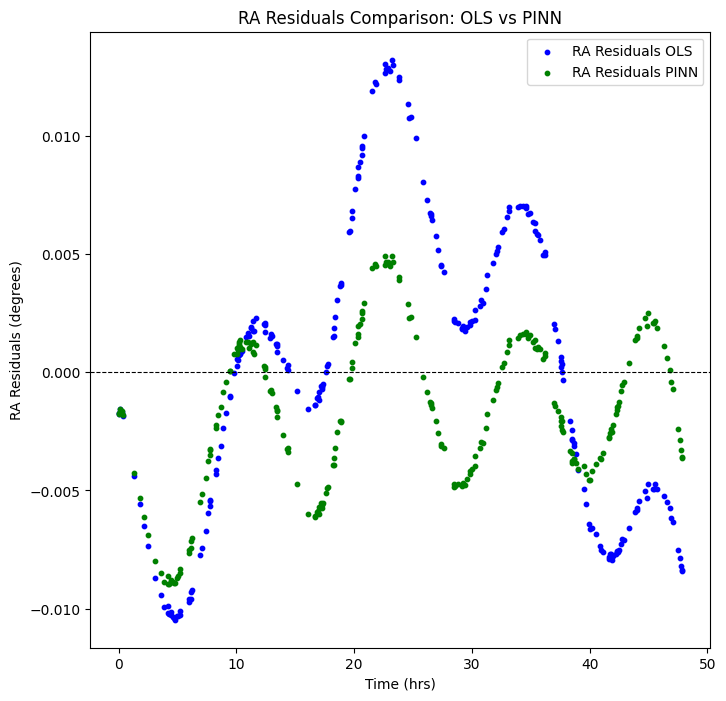

In [36]:
# plot RA residuals from both OLS and PINN methods
fig, ax = plt.subplots(figsize=(8, 8))
# Compute RA residuals accounting for circular nature (0-360 degrees)
ra_guess_deg_ols = ra_ols.detach().numpy()
ra_guess_deg_pinn = ra_guess_pinn.detach().numpy()
ra_obs_deg = ra_obs_noisy.detach().numpy()
ra_diff_rad_ols = np.radians(ra_guess_deg_ols - ra_obs_deg)
ra_diff_rad_pinn = np.radians(ra_guess_deg_pinn - ra_obs_deg)
ra_residuals_ols = np.degrees(np.arctan2(np.sin(ra_diff_rad_ols), np.cos(ra_diff_rad_ols)))
ra_residuals_pinn = np.degrees(np.arctan2(np.sin(ra_diff_rad_pinn), np.cos(ra_diff_rad_pinn)))
ax.scatter(observation_times/3600.0, ra_residuals_ols, color='blue', s=10, label='RA Residuals OLS')
ax.scatter(observation_times/3600.0, ra_residuals_pinn, color='green', s=10, label='RA Residuals PINN')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('RA Residuals (degrees)')
ax.set_title('RA Residuals Comparison: OLS vs PINN')
ax.legend()
plt.show()

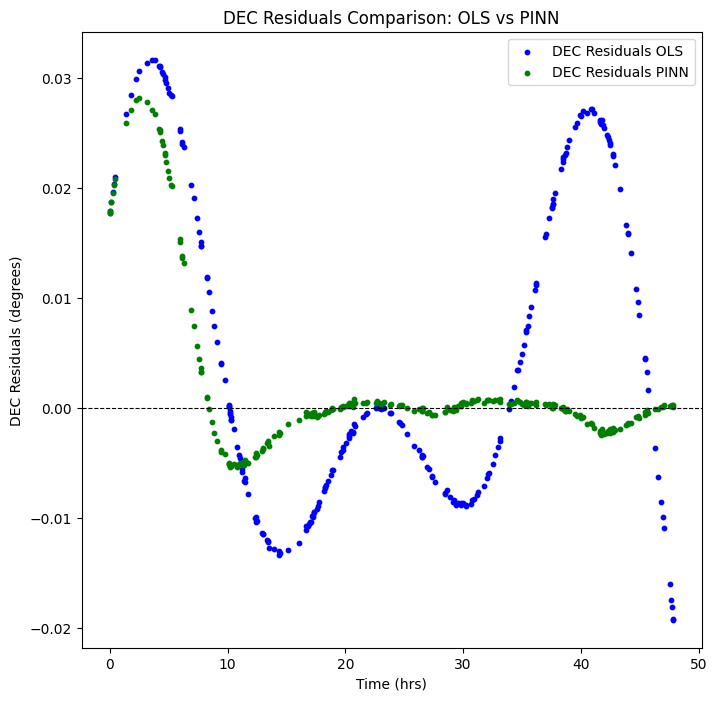

In [37]:
# plot DEC residuals from both OLS and PINN methods
fig, ax = plt.subplots(figsize=(8, 8))
# Compute DEC residuals accounting for circular nature (0-360 degrees)
dec_guess_deg_ols = dec_ols.detach().numpy()
dec_guess_deg_pinn = dec_guess_pinn.detach().numpy()
dec_obs_deg = dec_obs_noisy.detach().numpy()
dec_diff_rad_ols = np.radians(dec_guess_deg_ols - dec_obs_deg)
dec_diff_rad_pinn = np.radians(dec_guess_deg_pinn - dec_obs_deg)
dec_residuals_ols = np.degrees(np.arctan2(np.sin(dec_diff_rad_ols), np.cos(dec_diff_rad_ols)))
dec_residuals_pinn = np.degrees(np.arctan2(np.sin(dec_diff_rad_pinn), np.cos(dec_diff_rad_pinn)))
ax.scatter(observation_times/3600.0, dec_residuals_ols, color='blue', s=10, label='DEC Residuals OLS')
ax.scatter(observation_times/3600.0, dec_residuals_pinn, color='green', s=10, label='DEC Residuals PINN')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('DEC Residuals (degrees)')
ax.set_title('DEC Residuals Comparison: OLS vs PINN')
ax.legend()
plt.show()